In [2]:
import torch #import the library
import torch.nn.functional as F #for functions such as loss coputation
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github in the english language
!wget https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_names.txt

--2025-02-24 10:30:42--  https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11753 (11K) [text/plain]
Saving to: ‘animal_names.txt’

animal_names.txt    100%[===================>]  11.48K  --.-KB/s    in 0s      

2025-02-24 10:30:42 (51.1 MB/s) - ‘animal_names.txt’ saved [11753/11753]



In [4]:
words_en = open('animal_names.txt', 'r').read().splitlines() #open a file in read more and read the content of it, in addition split the file into a list with separted words
words_en = [word.replace("-", "").replace("'", "").replace(","," ").replace("’"," ").replace("."," ") for word in words_en] #replace/drop punctuation
words_en = [word.lower() for word in words_en]
words_en[:10] #show the first 10 words from the list



['aardvark',
 'albatross',
 'alligator',
 'alpaca',
 'anaconda',
 'angelfish',
 'ant',
 'anteater',
 'antelope',
 'armadillo']

In [5]:
len(words_en) # count the  number of words in the list

1044

In [6]:


# build the vocabulary of characters and mappings to/from integers (EN)
chars_en = sorted(list(set(''.join(words_en)))) #concatenates the words into a string, while organizing the characters into consisnt order
print(chars_en)
stoi_en = {s: i+1 for i, s in enumerate(chars_en)} #string to index
stoi_en['.'] = 0 # מראה ש. זה סיום מילה על ידי 0

# Remove numerical keys from stoi_en
stoi_en = {k: v for k, v in stoi_en.items() if not k.isdigit()} # Filter out numerical keys

print(stoi_en)

itos_en = {i: s for s, i in stoi_en.items()} #index to string
print(itos_en)




# build the dataset  in english
block_size = 3 #context length

def build_dataset(words_en): #converts the list of words into dataset
  X, Y = [], []
  for w in words_en:


    context = [0] * block_size #intializes a vector of length 3 into zeros
    for ch in w + '.': #adds a period in the end of words
      ix = stoi_en[ch] # get the index of the current character from stoi_en
      X.append(context) #previous 3 characters
      Y.append(ix) #next characters
      context = context[1:] + [ix] # crop and append

#tensor data formeat
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y #return to dateset

import random
random.seed(42) # make sure the the random shuffle is consistent
random.shuffle(words_en)
n1 = int(0.8*len(words_en)) #for training
n2 = int(0.9*len(words_en)) #for validation

Xtr_en, Ytr_en = build_dataset(words_en[:n1]) # Define Xtr_en, Ytr_en - convert to numerical -traning set
Xdev, Ydev = build_dataset(words_en[n1:n2])   #validation set
Xte, Yte = build_dataset(words_en[n2:]) #test set

 # קבלת רשימה של כל התווים ב-Xtr
all_chars_in_Xtr = set(Xtr_en.flatten().tolist())

# מציאת תווים חסרים
missing_chars = all_chars_in_Xtr - set(stoi_en.keys())

#adding special characters
next_index = max(stoi_en.values()) + 1
for char in missing_chars:
    stoi_en[char] = next_index
    next_index += 1


#Add handling for unknown characters
max_index_in_Xtr_en = torch.max(Xtr_en) # find the biggest index
if max_index_in_Xtr_en >= len(stoi_en): #find any character not in vocabulary
    print(f"Warning: Xtr contains indices greater than vocabulary size. Max index in Xtr: {max_index_in_Xtr_en}, Vocabulary size: {len(stoi_en)}")
    Xtr_en[Xtr_en >= len(stoi_en)] = 0 # replace unknown characters with a special token





[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
torch.Size([9374, 3]) torch.Size([9374])
torch.Size([1225, 3]) torch.Size([1225])
torch.Size([1119, 3]) torch.Size([1119])


In [71]:

g_en = torch.Generator().manual_seed(2147483647) # for reproducibility
C_en = torch.randn((80, 10), generator=g_en) #create a random embedding matrix ' 80 rows and 10 columns
W1_en = torch.randn((30, 200), generator=g_en) #take 30 values and map them to 200 neurons
b1_en = torch.randn(200, generator=g_en) #add a 200 size vector to each neuron
W2_en = torch.randn((200, 80), generator=g_en) #take 200 from first layer and maps to 80 outputs
b2_en = torch.randn(80, generator=g_en) #add 80 size vactor
parameters_en = [C_en, W1_en, b1_en, W2_en, b2_en] #grop the parameters into a list

In [34]:
sum(p.nelement() for p in parameters_en) # number of parameters in total in english

23080

In [35]:
#track gradients
for p in parameters_en:
  p.requires_grad = True

In [36]:
#create a range of learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [37]:
#here are enpty lists to store:
lri = [] #learning rate
lossi = [] #loss values
stepi = [] # traning steps

In [38]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr_en.shape[0], (32,))

  # forward pass
  emb = C_en[Xtr_en[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en) # (32, 100)
  logits = h @ W2_en + b2_en # (32, 27)
  loss = F.cross_entropy(logits, Ytr_en[ix])
  #print(loss.item())

  # backward pass
  for p in parameters_en:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters_en:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

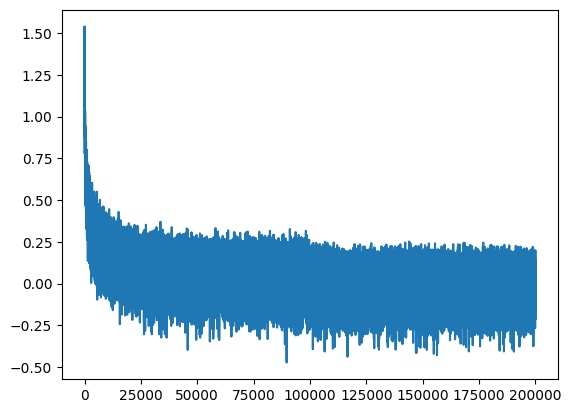

In [39]:
plt.plot(stepi, lossi)

In [40]:
# training loss
emb = C_en[Xtr_en] #retrive the embedding
h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en) #linar transformation  and tanh activation
logits = h @ W2_en + b2_en #complete logits
loss = F.cross_entropy(logits, Ytr_en)  #crentropyoss
loss #show the loss

tensor(1.0107, grad_fn=<NllLossBackward0>)

In [41]:
# validation loss
emb = C_en[Xdev] # retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en)  #linar transformation  and tanh activation
logits = h @ W2_en + b2_en  #complete logits
loss = F.cross_entropy(logits, Ydev)  #crentropyoss
loss #show loss

tensor(2.8844, grad_fn=<NllLossBackward0>)

In [42]:
# test loss
emb = C_en[Xte] #  retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en) # linar transformation  and tanh activation
logits = h @ W2_en + b2_en #complete logits
loss = F.cross_entropy(logits, Yte)  #crentropyoss
loss #show loss

tensor(2.5022, grad_fn=<NllLossBackward0>)

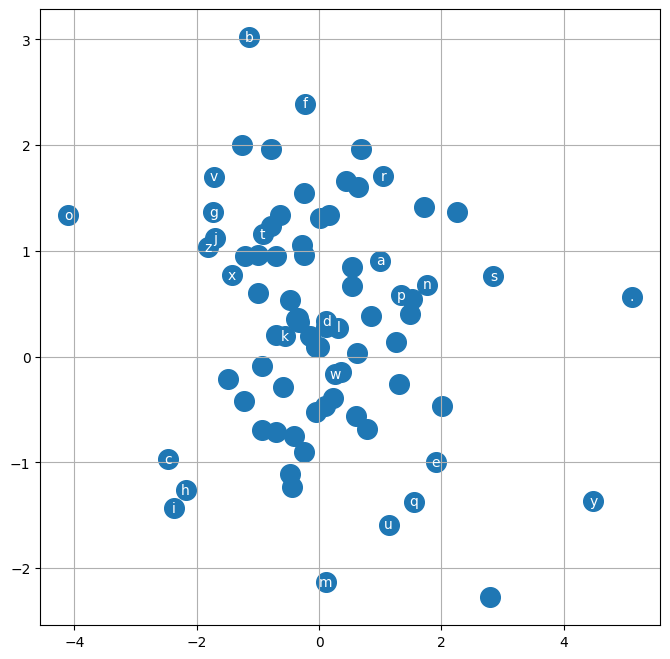

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(C_en[:,0].data, C_en[:,1].data, s=200)

for i in range(C_en.shape[0]):
    letter = itos_en.get(i, "")  # אם i לא קיים במילון, נחזיר מחרוזת ריקה
    plt.text(C_en[i, 0].item(), C_en[i, 1].item(),
             letter,
             ha="center", va="center", color='white')

plt.grid('minor')
plt.show()


In [45]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) #set a random seed

for _ in range(20): #generate 20 names

    out = [] # make an empty list to store generated names
    context = [0] * block_size # initialize with all zeros
    while True: #keep generating
      emb = C_en[torch.tensor([context])] # (retrieve the embeddings
      h = torch.tanh(emb.view(1, -1) @ W1_en + b1_en) #comute hidden layer activation with tanh
      logits = h @ W2_en + b2_en # compute final output layer
      probs = F.softmax(logits, dim=1) #apply softmax
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() #sample the next character with the right probability
      context = context[1:] + [ix] #update the context
      out.append(ix) #store the charcter to outpot list
      if ix == 0: #when reacing the stop token ,stop generating
        break

    print(''.join(itos_en[i] for i in out))

asian lobstern duckoo.
koalamarinian cat.
crimp.
dog.
greotamute.
dor.
pelack panther.
pelicary.
austral bee.
bis.
dodo dog.
anther.
alligator pengller.
kangearedtainteater.
axoloth.
albat.
tomatode.
mouse deer.
goat.
pygmy egreoth.


the spanish model

In [46]:
import torch #import the library
import torch.nn.functional as F #for functions such as loss coputation
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [47]:
# download the names.txt file from github in Spanish
!wget https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_spanish.txt

--2025-02-24 10:51:48--  https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_spanish.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20488 (20K) [text/plain]
Saving to: ‘animal_spanish.txt’

animal_spanish.txt  100%[===================>]  20.01K  --.-KB/s    in 0s      

2025-02-24 10:51:48 (78.4 MB/s) - ‘animal_spanish.txt’ saved [20488/20488]



In [48]:
words_sp = open('animal_spanish.txt', 'r').read().splitlines() #open a file in read more and read the content of it, in addition split the file into a list with separted words
words_sp = [word.replace("-", "").replace("'", "").replace(","," ") for word in words_sp]
words_sp = [word.lower() for word in words_sp]
words_sp[:8] #show the first 8 words from the list

['abeja',
 'águila',
 'albatros',
 'alce',
 'almeja',
 'anaconda',
 'anguila',
 'antílope']

In [49]:
len(words_sp) #cound words

1052

In [50]:
# build the vocabulary of characters and mappings to/from integers (SP)
chars_sp = sorted(list(set(''.join(words_sp))))  #concatenates the words into a string, while organizing the characters into consisnt order
stoi_sp = {s:i+1 for i,s in enumerate(chars_sp)}  #string to index
stoi_sp['.'] = 0   #index to string
itos_sp = {i:s for s,i in stoi_sp.items()}
print(itos_sp)


# build the dataset in Spanish
block_size = 3 # context length
def build_dataset(words_sp): #converts the list of words into dataset
  X, Y = [], []
  for w in words_sp:

    context = [0] * block_size  #intializes a vector of length 3 into zeros
    for ch in w + '.':    #adds a period in the end of words
      ix = stoi_sp[ch]   #characters to numerical index
      X.append(context)  #previous 3 characters
      Y.append(ix)    #next characters

      context = context[1:] + [ix] # crop and append

#tensor data formeat
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y  #return to dateset


import random
random.seed(42)  #make sure the the random shuffle is consistent
random.shuffle(words_sp)
n1 = int(0.8*len(words_sp))  #for training
n2 = int(0.9*len(words_sp))   #for validation

Xtr_sp, Ytr_sp = build_dataset(words_sp[:n1])  # Define Xtr_en, Ytr_en - convert to numerical -traning set
Xdev_sp, Ydev_sp = build_dataset(words_sp[n1:n2])  #validation set
Xte_sp, Yte_sp = build_dataset(words_sp[n2:])    #test set


#Add handling for unknown characters
max_index_in_Xtr_sp  = torch.max(Xtr_sp) # find the biggest index
if max_index_in_Xtr_en >= len(stoi_sp): #find any character not in vocabulary

    print(f"Warning: Xtr_sp contains indices greater than vocabulary size. Max index in Xtr: {max_index_in_Xtr_sp}, Vocabulary size: {len(stoi_sp)}")
    # Option 1: Replace unknown indices with a special token (e.g., 0 for unknown)
    Xtr_sp[Xtr_sp >= len(stoi_sp)] = 0 ## replace unknown characters with a special token





{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'á', 29: 'é', 30: 'í', 31: 'ñ', 32: 'ó', 33: 'ú', 34: 'ü', 0: '.'}
torch.Size([16046, 3]) torch.Size([16046])
torch.Size([2079, 3]) torch.Size([2079])
torch.Size([1905, 3]) torch.Size([1905])


In [51]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words_sp):
  X, Y = [], []
  for w in words_sp:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi_sp[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos_sp[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words_sp)
n1 = int(0.8*len(words_sp))
n2 = int(0.9*len(words_sp))

Xtr_sp, Ytr_sp = build_dataset(words_sp[:n1])
Xdev_sp, Ydev_sp = build_dataset(words_sp[n1:n2])
Xte_sp, Yte_sp = build_dataset(words_sp[n2:])

torch.Size([15795, 3]) torch.Size([15795])
torch.Size([2114, 3]) torch.Size([2114])
torch.Size([2121, 3]) torch.Size([2121])


In [52]:
g_sp = torch.Generator().manual_seed(2147483647) # for reproducibility
C_sp = torch.randn((80, 10), generator=g) #create a random embedding matrix ' 80 rows and 10 columns
W1_sp = torch.randn((30, 200), generator=g) #take 30 values and map them to 200 neurons
b1_sp = torch.randn(200, generator=g)  #add a 200 size vector to each neuron
W2_sp = torch.randn((200, 80), generator=g) #take 200 from first layer and maps to 80 outputs
b2_sp = torch.randn(80, generator=g)  #add 80 size vactor
parameters_sp = [C_sp, W1_sp, b1_sp, W2_sp, b2_sp]  #grop the parameters into a list

In [53]:
sum(p.nelement() for p in parameters_sp) # number of parameters in total in spanish

23080

In [54]:
#track gradients
for p in parameters_sp:
  p.requires_grad = True

In [55]:
#here are empty lists to store:

lri = [] #learning rate
lossi = [] #loss values
stepi = []# traning steps

In [56]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr_sp.shape[0], (32,))

  # forward pass
  emb = C_sp[Xtr_sp[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp)
  logits = h @ W2_sp + b2_sp
  loss = F.cross_entropy(logits, Ytr_sp[ix])

  # backward pass
  for p in parameters_sp:
    p.grad = None
  loss.backward()


  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters_sp:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

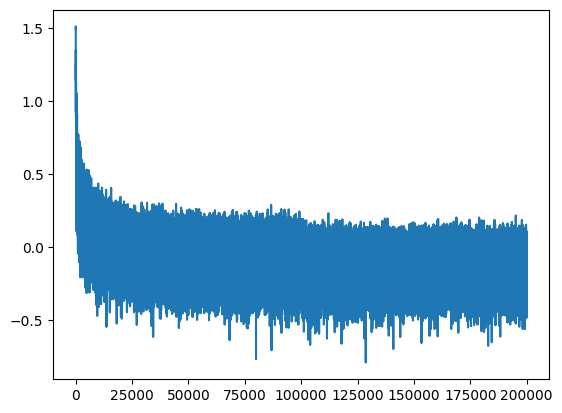

In [57]:
plt.plot(stepi, lossi)

In [58]:
# training loss
emb = C_sp[Xtr_sp] ##retrive the embedding
h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp) #linar transformation  and tanh activation
logits = h @ W2_sp + b2_sp # (32, 27) #complete logits
loss = F.cross_entropy(logits, Ytr_sp) #crentropyoss
loss #show the loss

tensor(0.7778, grad_fn=<NllLossBackward0>)

In [59]:
 #validation loss
emb = C_sp[Xdev] # retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp)  #linar transformation  and tanh activation
logits = h @ W2_sp + b2_sp  #complete logits
loss = F.cross_entropy(logits, Ydev)  #crentropyoss
loss #show loss

tensor(7.8303, grad_fn=<NllLossBackward0>)

In [60]:
# test loss
emb = C_sp[Xte] #  retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp) # linar transformation  and tanh activation
logits = h @ W2_sp + b2_sp #complete logits
loss = F.cross_entropy(logits, Yte)  #crentropyoss
loss #show loss

tensor(8.3843, grad_fn=<NllLossBackward0>)

In [61]:
print("Characters in stoi_sp:", stoi_sp) # check the character-to-index mapping


Characters in stoi_sp: {' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'á': 28, 'é': 29, 'í': 30, 'ñ': 31, 'ó': 32, 'ú': 33, 'ü': 34, '.': 0}


In [62]:
#chaking the missing characters
missing_chars = []

for i in range(C_sp.shape[0]):
    if i not in itos_sp:
        missing_chars.append(i)

print("Missing characters in itos_sp:", missing_chars)

Missing characters in itos_sp: [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


In [63]:
# adding the missing characters
missing_chars = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

for char_index in missing_chars:
    itos_sp[char_index] = "?"  # adding general sign to unknown characters

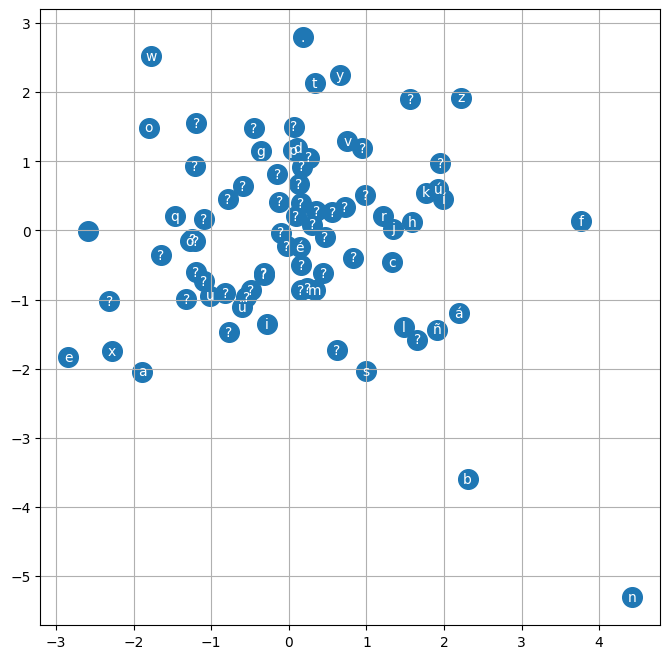

In [64]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8)) #create a figure of 8 and 8 size
plt.scatter(C_sp[:,0].data, C_sp[:,1].data, s=200) #plot a scatter
for i in range(C_sp.shape[0]):
    # Check if the key 'i' exists in itos_sp before accessing it
    # If the key doesn't exist, use a placeholder character (e.g., '?')
    char = itos_sp.get(i, "?")
    plt.text(C_sp[i,0].item(), C_sp[i,1].item(), char, ha="center", va="center", color='white')
plt.grid('minor')

In [65]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) #set a random seed

for _ in range(20):  #generate  names

    out = [] # make an empty list to store generated names
    context = [0] * block_size ## initialize with all zeros
    while True: #keep generating
      emb = C_sp[torch.tensor([context])] # retrieve the embeddings
      h = torch.tanh(emb.view(1, -1) @ W1_sp + b1_sp) #compute hidden layer activation with tanh
      logits = h @ W2_sp + b2_sp  # compute final output layer
      probs = F.softmax(logits, dim=1) #apply softmax
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() #sample the next character with the right probability
      context = context[1:] + [ix] #update the context
      out.append(ix)  #store the charcter to outpot list
      if ix == 0:  #when reacing the stop token ,stop generating
        break

    print(''.join(itos_sp[i] for i in out))

anta verdillande.
campo.
bicho zigzagueo volcánico.
cierto.
chincho zigzagueo saharaña banrtado.
foca azul.
bicho zigzagueo estal.
bicho zigzagueo japonte.
bicho zigzagueo tetraldimensional.
corpión bameria.
escorana fante.
bicho zigzagueo azul.
hientularileta.
cisne duponte.
hormigarrera.
ardimensiona jorrileta.
armónico primilla comatero.
vena gallega.
bicho zigzagueo volcánico univerdilla de perde.
bicho zigzaguarina filipinte de del amar.


part two
after buliding  and traning the two models in english and spanish to learn  the strecure and patterns of each language, the next step is to eveluate id they can apply the rules they learned in one language and generated words in the other language.this stap will test the models ability to transfer linguistics knowledge between languages


In [66]:
def evaluate_model(X, Y, C, W1, b1, W2, b2): # take different parameters and caculated the loss for the dataset : x-input data , y- targat data ,c- embadding matrix, w1+b1-first layer, w2+b2- second layer

    emb = C[X] # retrieved the character embedding  for x from c
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # to make the embedding go trough to first layer
    logits = h @ W2 + b2 # h(transfered data) is passed through the second layer
    loss = F.cross_entropy(logits, Y) #compute loss between logits and Y
    return loss #returen evaluation of loss
#eveluating english model on english data
loss_en = evaluate_model(Xtr_en, Ytr_en, C_en, W1_en, b1_en, W2_en, b2_en) # caculate the loss of english model on english data
print(f"Evaluating English model loss on English data: {loss_en}")

#eveluating spanish model on spanish data
loss_sp = evaluate_model(Xtr_sp, Ytr_sp, C_sp, W1_sp, b1_sp, W2_sp, b2_sp) # caculate the loss of spanish  model on spanish data
print(f"Evaluating Spanish model loss on Spanish data: {loss_sp}")

Evaluating English model loss on English data: 1.0107197761535645
Evaluating Spanish model loss on Spanish data: 0.7778291702270508


In [67]:
#eveluating english model on spanish data
loss_en_on_sp = evaluate_model(Xtr_sp, Ytr_sp, C_en, W1_en, b1_en, W2_en, b2_en) # caculate the loss of english model on spanish  data
print(f"Evaluating English model loss on Spanish data: {loss_en_on_sp}")

#eveluating spanish model on english  data
loss_sp_on_en = evaluate_model(Xtr_en, Ytr_en, C_sp, W1_sp, b1_sp, W2_sp, b2_sp) # caculate the loss of spanish model on english data
print(f"Evaluating Spanish model loss on English data: {loss_sp_on_en}")


Evaluating English model loss on Spanish data: 9.259305000305176
Evaluating Spanish model loss on English data: 8.33609676361084


In [68]:
import torch
import torch.nn.functional as F

def generate_names(C, W1, b1, W2, b2, itos, num_names=10, block_size=3): #generate new names based on the trained models. c-embeddig matrix, w1+b1-first wiget matrix for hidden layer, w2+b2- second weight matrix for outpot, itos- maps integer ingices back to characters,num_numes- number of generate names , block_size-length of context

    g = torch.Generator().manual_seed(2147483647 + 10)
    generated_names = []

    for _ in range(num_names):
        out = []
        context = [0] * block_size  # Initialize with all ...
        while True:
            emb = C[torch.tensor([context])]  # (1, block_size, d)
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        generated_names.append(''.join(itos[i] for i in out))

    return generated_names

In [69]:
# in those lines I tried to generate spanish names with english model and visa
# varsa, however since there are some characters In  spanish that are not
# part from the english modal therfore the model cannot run it.(it supposed to fail)
print("Generating Spanish names with English model...")
generate_names(C_en, W1_en, b1_en, W2_en, b2_en, itos_sp, num_names=10) # Using itos_sp יתfor Spanish names


print("Generating English names with Spanish model...")
generate_names(C_sp, W1_sp, b1_sp, W2_sp, b2_sp, itos_en, num_names=10) #  the error is in this line in the "itos_en" part

Generating Spanish names with English model...
Generating English names with Spanish model...


KeyError: 28

In [70]:
# in this part we can see the generated names since they are generated only from the "itos_sp' that inculde all the characters
print("Generating Spanish names with English model...")
generate_names(C_en, W1_en, b1_en, W2_en, b2_en, itos_sp, num_names=10) # Using itos_sp for Spanish names


print("Generating English names with Spanish model...")
generate_names(C_sp, W1_sp, b1_sp, W2_sp, b2_sp, itos_sp, num_names=10) # Using itos_sp, not itos_en

Generating Spanish names with English model...
Generating English names with Spanish model...


['anta verdillande.',
 'campo.',
 'bicho zigzagueo volcánico.',
 'cierto.',
 'chincho zigzagueo saharaña banrtado.',
 'foca azul.',
 'bicho zigzagueo estal.',
 'bicho zigzagueo japonte.',
 'bicho zigzagueo tetraldimensional.',
 'corpión bameria.']